# OpenCV、Dlib、MediaPipe ｰデータ分析ｰ

以下のコードを参考に、画像認識で得たデータの活用を理解してください。
各教材を解きながら、データの加工や可視化、データ分析の流れを学んでください。

### 人通りの変化をグラフで確認する

In [1]:
import cv2
import pandas as pd

print("分析を開始します")

# 動画ファイルの読み込み
cap = cv2.VideoCapture("vtest.avi")

# 動画のフレームレート（FPS）を取得
fps = cap.get(cv2.CAP_PROP_FPS)

# HOG（Histogram of Oriented Gradients）人物検出器の設定
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())
hogParams = {
    'winStride': (4, 4),    # 検出ウィンドウの移動ステップ
    'padding': (8, 8),      # 検出ウィンドウの周りのパディング
    'scale': 1.05,          # 画像ピラミッドのスケール
    'hitThreshold': 0       # 検出閾値
}

num = 0  # フレームカウンター
# 結果を格納するためのデータフレームを初期化
list_df = pd.DataFrame(columns=['time', 'people'])

while(cap.isOpened()):
    ret, frame = cap.read()  # フレームを1つ読み込む
    if ret:
        if (num % 10 == 0):  # 10フレームごとに処理
            # グレースケールに変換（人物検出の精度向上のため）
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # 人物検出を実行
            human, r = hog.detectMultiScale(gray, **hogParams)
            
            if (len(human) > 0):  # 人物が検出された場合
                for (x, y, w, h) in human:
                    # 検出された人物を白い矩形で囲む
                    cv2.rectangle(frame, (x, y), (x + w, y + h), (255,255,255), 3)
            
            # 時間と検出された人数をデータフレームに追加
            tmp_df = pd.DataFrame([[num/fps, len(human)]], columns=list_df.columns)
            list_df = pd.concat([list_df, tmp_df], ignore_index=True)
            
            # 検出結果を表示
            cv2.imshow('frame', frame)
            # 'q'キーが押されたらループを終了
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    else:
        break  # 動画の終わりに達したらループを終了
    
    num += 1  # フレームカウンターを増加

# リソースの解放
cap.release()
cv2.destroyAllWindows()

print("分析を終了しました")
# この時点で list_df には時間と検出された人数のデータが格納されています

分析を開始します


C:\Users\merue\AppData\Local\Temp\ipykernel_30524\1981589504.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  list_df = pd.concat([list_df, tmp_df], ignore_index=True)


分析を終了しました


### グラフプロット 

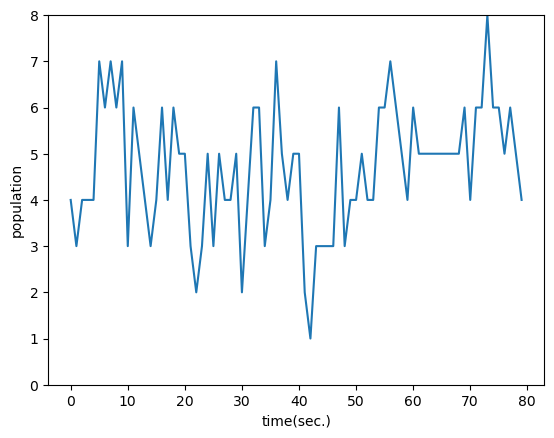

In [2]:
# matplotlib ライブラリをインポート
import matplotlib.pyplot as plt

# list_dfは既に存在すると仮定します

# 時間と人数のグラフを作成
plt.plot(list_df["time"], list_df["people"])

# X軸のラベルを設定
plt.xlabel('time(sec.)')

# Y軸のラベルを設定
plt.ylabel('population')

# Y軸の範囲を0から8に設定
plt.ylim(0, 8)

# グラフを表示
plt.show()

### PELTアルゴリズムを用いた変化点検出

検出された変化点のインデックス: [5, 10, 40, 50, 80]


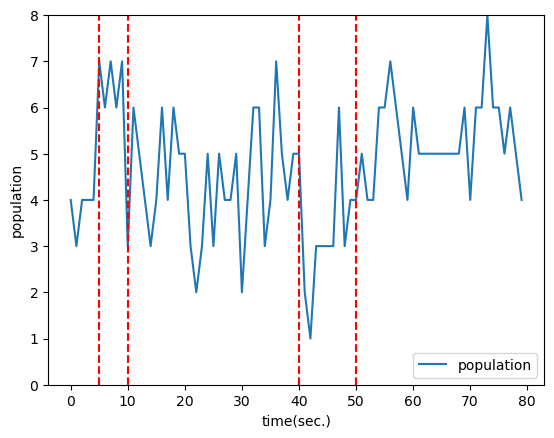

In [3]:
import ruptures as rpt
import matplotlib.pyplot as plt

# list_dfは既に存在すると仮定します

# 人数データを抽出
signal = list_df['people'].values

# モデルの選択（"l1", "l2", "rbf"など）
model = "l1"

# PELTアルゴリズムを使用して変化点検出を実行
algo = rpt.Pelt(model=model).fit(signal)

# ペナルティ値の設定（変化点の数を調整）
penalty = 3  # 必要に応じて調整

# 変化点のインデックスを取得
result = algo.predict(pen=penalty)

# 検出された変化点を表示
print("検出された変化点のインデックス:", result)

# 時間と人数のプロットを作成し、変化点を表示
plt.plot(list_df['time'], signal, label='population')

# 検出された変化点に垂直線を引く
for cp in result[:-1]:  # 最後のポイントは信号の終わりなので除外
    plt.axvline(x=list_df['time'].iloc[cp], color='red', linestyle='--')

plt.xlabel('time(sec.)')
plt.ylabel('population')
# Y軸の範囲を0から8に設定
plt.ylim(0, 8)
plt.legend()
plt.show()


### 移動平均を計算することでノイズの影響を除去する

In [4]:
import numpy as np
def moving_average(x, y):
    y_conv = np.convolve(y, np.ones(5)/float(5), mode='valid')
    x_dat = np.linspace(np.min(x), np.max(x), np.size(y_conv))
    return x_dat, y_conv

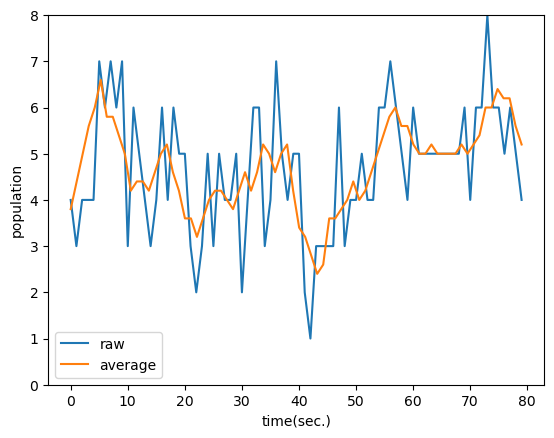

In [5]:
plt.plot(list_df["time"], list_df["people"], label="raw")
ma_x, ma_y = moving_average(list_df["time"], list_df["people"])
plt.plot(ma_x,ma_y, label="average")
plt.xlabel('time(sec.)')
plt.ylabel('population')
plt.ylim(0,8)
plt.legend()
plt.show()

## 到達度確認

課題1：Webカメラの読み込みと人物検出
* Webカメラを読み込み、OpenCVを用いて人物検出を行い、検出した人数を時間とともに記録してみよう。
* Dlibを用いて動画内の顔を検出を行い、検出した顔数を時間とともに記録してみよう。
     
課題2：人数データの可視化
* 課題1で取得した人数および顔数データを用いて、時間に対する値の変化をグラフで表示してみよう。

課題3：データのCSV保存
* list_dfに記録されたきデータをCSVファイルに保存し、後からデータを再利用できるようにしてみよう。